In [4]:
#@title Installations
%pip install pandas numpy matplotlib seaborn medmnist scikit-learn Pillow tensorflow


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /opt/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
#@title Imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 
from medmnist import RetinaMNIST
import PIL as pill
import pandas as pd
from collections import Counter 
from abc import ABC, abstractmethod
from typing import Sequence
import seaborn as sns;
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
#@title Dataset Download
train = RetinaMNIST(split='train',download=True,size=64)
test = RetinaMNIST(split='test',download=True,size=64)
val = RetinaMNIST(split='val',download=True,size=64)

Using downloaded and verified file: /Users/saiharshagangari/.medmnist/retinamnist_64.npz
Using downloaded and verified file: /Users/saiharshagangari/.medmnist/retinamnist_64.npz
Using downloaded and verified file: /Users/saiharshagangari/.medmnist/retinamnist_64.npz


*********        Dataset Description        *********
Dataset RetinaMNIST of size 64 (retinamnist_64)
    Number of datapoints: 1080
    Root location: /Users/saiharshagangari/.medmnist
    Split: train
    Task: ordinal-regression
    Number of channels: 3
    Meaning of labels: {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'}
    Number of samples: {'train': 1080, 'val': 120, 'test': 400}
    Description: The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.
    License: CC BY 4.0
*********        Plotting sample images        *********


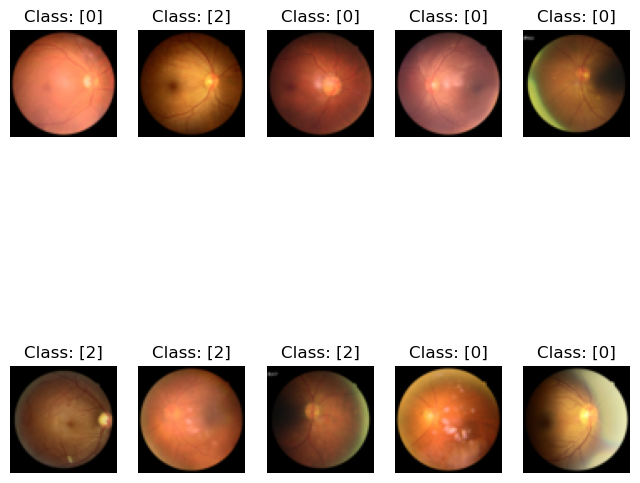

In [7]:
#@title Elementary Data Analysis
#Determine each category format: {class label, train sample count}
#RetinaMNIST = " {0:486, 1:128, 2:206, 3: 194, 4: 66}"
train_dataset = list(train)

def describe_dataset(train_data):
    print(train)

def plot_images(train_subset):
    try:
        figure, axes = plt.subplots(2,5, figsize=(8,8))
        axes = axes.flatten()
        for id in range(0,10):
            img,lbl = train_subset[id]
            axes[id].imshow(img)
            axes[id].set_title(f'Class: {lbl}')
            axes[id].axis('off')
        plt.show()

                
    except Exception as e:
        print('Error' ,e) 

print('*********        Dataset Description        *********')
describe_dataset(train)

print('*********        Plotting sample images        *********')
sample_subset = list(train)[570:580]
plot_images(sample_subset)


*****          Visualize class 4 samples       ********


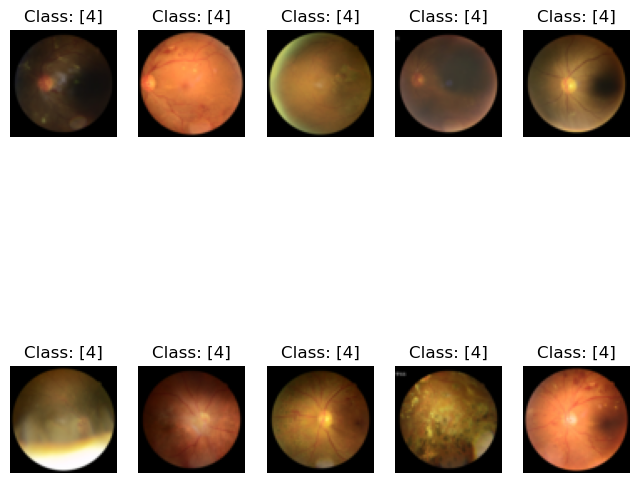

 ********         Shape of image         ********
shape of image: (64, 64) and label size:  1


(<PIL.Image.Image image mode=RGB size=64x64>, array([0]))

In [8]:
# <h3>EDA Part 2</h3>
class4_dataset = [x for x in train_dataset if x[1] == 4]

print("*****          Visualize class 4 samples       ********")
plot_images(class4_dataset[1:11])

print(" ********         Shape of image         ********")
image = class4_dataset[0][0]
label = class4_dataset[0][1]
print(f"shape of image: {image.size} and label size:  {label.size}")
train[0]




In [9]:
#@title Base Algorithm
class BaseLearningAlogrithm(ABC):
    @abstractmethod
    def fit(self,xtrain:np.array,ytrain:np.array,xval:np.array,yval:np.array) -> tf.keras.callbacks.History:
        """Implement custom logic to train the GAN using train and validation data"""
    
    @abstractmethod
    def predict(self,xtest:list,ytest:list)->list:
        """Implement custom logic to test the GAN using test data"""
    
    @property
    @abstractmethod
    def name(self)->str:
        """Returns algorithm name"""
    
    @property
    def layers(self)-> Sequence[tf.keras.layers.Layer]:
        raise NotImplementedError()
    
    @property
    def input(self):
        raise NotImplementedError()


In [10]:
#@title Utility methods
def normalize_image(data):
    return data.astype('float32')/255.0

def prepare_x_y_columns(data:list):
    X = [np.array(sample[0]) for sample in data]
    Y = [np.array(sample[1]) for sample in data]
    X = normalize_image(np.array(X,dtype='float32'))
    Y = np.squeeze(to_categorical(np.array(Y,dtype='int'),num_classes=5))
    return (X,Y)

In [11]:
#@title Training and Evaluation methods
def train_eval(learning_algo: BaseLearningAlogrithm, ds_train, ds_val, ds_test):
  """Trains and evaluates the generic model."""
  
  history = learning_algo.fit(ds_train[0],ds_train[1], ds_val[0],ds_val[1])

  y_test = ds_test[1]
  images = ds_test[0]
  print('val input shape :',images.shape)
  y_pred =  learning_algo.predict(images) 

  print("*******   Confusion Matrix *********")
  mat = confusion_matrix(y_test, y_pred)
  sns.set(rc = {'figure.figsize':(5,5)})
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
              xticklabels=['%d' %i for i in range(5)],
              yticklabels=['%d' %i for i in range(5)])
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.title(learning_algo.name)

  print("*******   Classification Report: *********")
  print(classification_report(y_test, y_pred,
                              target_names=['%d' %i for i in range(5)]))
  
  return history



(1080, 64, 64, 3) (1080, 5)
[0. 1. 0. 0. 0.]
(120, 64, 64, 3)
(400, 64, 64, 3)
Running fit method of CNN
current epoch 0 current learning rate:  0.0008999999845400453
Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.3916 - f1_score: 0.1721 - loss: 1.9086 - precision: 0.4783 - recall: 0.0839 - val_accuracy: 0.4500 - val_f1_score: 0.1241 - val_loss: 1.5169 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 9.0000e-04
current epoch 1 current learning rate:  0.0008999999845400453
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.4339 - f1_score: 0.1231 - loss: 1.4544 - precision: 0.4857 - recall: 0.0897 - val_accuracy: 0.4500 - val_f1_score: 0.1241 - val_loss: 1.2834 - val_precision: 0.8095 - val_recall: 0.2833 - learning_rate: 9.0000e-04
current epoch 2 current learning rate:  0.0008999999845400453
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.4455 - f1_score: 0.1327 - loss: 1.3235 - precision: 0.7667 - recall: 0.2326 - val

/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


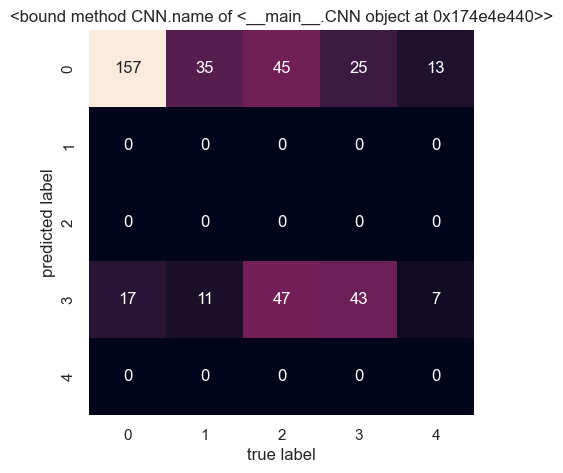

In [ ]:
#@title Create a CNN to establish benchmark
class CNN(BaseLearningAlogrithm):
    def __init__(self):
        self.epochs = 30
        self.loss = tf.losses.CategoricalCrossentropy()
        self.model = self.getmodel()
        self.learning_rate = 3e-4

        # self.learning_rate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(self.scheduler,self.epochs,self.learning_rate)
        self.optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate)
        self.history = None
    
    def scheduler(self,epoch,currLearningRate):
        print('current epoch', epoch, 'current learning rate: ',currLearningRate)
        if epoch <= 15:
            return currLearningRate
        elif 16<= epoch <=30:
            return currLearningRate-currLearningRate*0.02
        elif 31<= epoch <= 45:
            return currLearningRate - currLearningRate*0.3
        elif 46<= epoch <=70:
            return currLearningRate - currLearningRate*0.45
        elif epoch>70:
            return currLearningRate * ((1-(epoch/self.epochs))**2)

    def name(self)->str:
        return 'Base CNN'
    
    def getmodel(self)->tf.keras.models.Sequential:
        cnn_model = tf.keras.models.Sequential([
            # # **********       Build the convolutional layers   *********
            tf.keras.layers.Input(shape=(64,64,3)),
            tf.keras.layers.Conv2D(filters=150,kernel_size=25,activation='relu',padding='same'),
            tf.keras.layers.MaxPool2D(pool_size=3,strides=2),
            tf.keras.layers.Conv2D(filters=100,kernel_size=15,activation='relu',padding='same'),
            tf.keras.layers.MaxPool2D(pool_size=2,strides=1),
            tf.keras.layers.Conv2D(filters=50,kernel_size=10,activation='relu',padding='same'),
            tf.keras.layers.MaxPool2D(pool_size=2,strides=1),
            tf.keras.layers.Conv2D(filters=10,kernel_size=2,activation='relu',padding='same'),
            tf.keras.layers.AvgPool2D(pool_size=2,strides=2),

            tf.keras.layers.Flatten(), # Flatten the layers

            #***********     Start of Feed forward Neural Network       **********
            tf.keras.layers.Dense(225,activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(150,activation='relu'),
            tf.keras.layers.Dropout(0.33),
            tf.keras.layers.Dense(80,activation='relu'),
            tf.keras.layers.Dense(30,activation='relu'),
            tf.keras.layers.Dropout(0.25),
            # tf.keras.layers.Dense(10,activation='relu'),
            tf.keras.layers.Dropout(0.1),

            #***********      Output layer       **********
            tf.keras.layers.Dense(5,activation='softmax')
            
        ])
        return cnn_model
    
    def fit(self,xtrain,ytrain,xval,yval)->Sequence[tf.keras.callbacks.History]:
        print('Running fit method of CNN')
        callback = tf.keras.callbacks.LearningRateScheduler(self.scheduler)
        self.model.compile(optimizer=self.optimizer,loss=self.loss,metrics=['accuracy','f1_score','precision','recall'])
        self.history = self.model.fit(xtrain,ytrain, epochs=self.epochs,validation_data=(xval,yval),callbacks=[callback])
        return self.history
    
    def predict(self,xtest):
        return np.argmax(self.model.predict(xtest),axis=1)


X_train, Y_train = prepare_x_y_columns(train_dataset)
print(X_train.shape,Y_train.shape)
print(Y_train[40])

val_dataset = list(val)
X_val,Y_val = prepare_x_y_columns(val_dataset)
print(X_val.shape)


test_dataset = list(test)
X_test,Y_test = prepare_x_y_columns(test_dataset)
print(X_test.shape)
Y_test = np.argmax(Y_test,axis=1)



cnn_model = CNN()
history = train_eval(cnn_model,(X_train,Y_train),(X_val,Y_val),(X_test,Y_test))



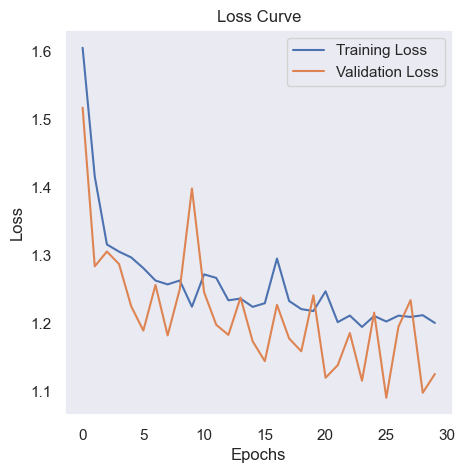

In [13]:

# Assuming 'history' is your History object
def plot_loss_curve(history):
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:  # Check if validation loss is available
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Call the function to plot the curve

plot_loss_curve(history)


In [ ]:
#@title Extracting AUC Score of the above CNN model
auc = tf.metrics.AUC()
auc.update_state()

In [14]:
cnn_model.model.save('/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/accuracy56_weights.keras')

In [15]:
#@title Model Architecture - Generator


In [16]:
#@title Model Architecture - Discriminator

In [17]:
#@title Run

In [18]:
#@title Results